In [1]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
from credentials import user
from credentials import server
from credentials import password
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from credentials import user, password, server

In [2]:
engine = create_engine("postgres+psycopg2://"+user+":"+password+"@"+server+":5432/covid_data")

In [3]:
service_requests_df = pd.read_csv('C:/Users/Natalia/Documents/NSS/class_projects/nashville-covid-quaranteam/data/hubNashville_311_Service_Requests.csv', low_memory=False)
clusters_df = pd.read_csv('C:/Users/Natalia/Documents/NSS/class_projects/nashville-covid-quaranteam/data/clusters.csv', low_memory=False)
businesses_df = pd.read_csv('C:/Users/Natalia/Documents/NSS/class_projects/nashville-covid-quaranteam/data/businesses.csv', low_memory=False)

In [4]:
service_requests_df.head(2)

,Request #,Status,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Date / Time Closed,Request Origin,System of Origin ID,Contact Type,...,State Issue,Parent Request,Closed When Created,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
0,113016,Closed,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,03/05/2019 09:35:00 PM,Phone,NaN,NaN,...,False,NaN,False,2009 Upland Dr,NASHVILLE,7.0,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,53502,Closed,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,04/06/2018 01:13:32 PM,Phone,NaN,NaN,...,False,NaN,False,631 Murfreesboro Pike,NASHVILLE,17.0,37210,36.140070,-86.738360,"(36.14007, -86.73836)"


In [5]:
clusters_df.head(2)

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583


In [6]:
businesses_df.head(2)

,address,vicinity,name,type
0,"2440 COUCHVILLE PIKE, Nashville","2440 Couchville Pike, Nashville",Wilson Sporting Goods Co,"['point_of_interest', 'establishment']"
1,"1613 Buchanan St, Nashville","1613 Buchanan Street, Nashville",Coin Cloud Bitcoin ATM,"['atm', 'finance', 'point_of_interest', 'estab..."


In [7]:
service_requests_filtered = service_requests_df[['Request Type','Subrequest Type','Additional Subrequest Type','Date / Time Opened','Address', 'City','ZIP','Latitude','Longitude','Mapped Location']]
service_requests_filtered.head(2)

,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Address,City,ZIP,Latitude,Longitude,Mapped Location
0,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,2009 Upland Dr,NASHVILLE,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,631 Murfreesboro Pike,NASHVILLE,37210,36.140070,-86.738360,"(36.14007, -86.73836)"


In [8]:
service_requests_dropped_nan = service_requests_filtered.dropna()
service_requests_dropped_nan.head(2)

,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Address,City,ZIP,Latitude,Longitude,Mapped Location
0,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,2009 Upland Dr,NASHVILLE,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,631 Murfreesboro Pike,NASHVILLE,37210,36.140070,-86.738360,"(36.14007, -86.73836)"


In [9]:
service_requests_renamed = service_requests_dropped_nan.rename(columns={'Request Type':'req_type', 'Subrequest Type':'subreq_type','Additional Subrequest Type':'add_subreq_type','Date / Time Opened':'date_time','Address':'address','City':'city','ZIP':'zip','Latitude':'lat','Longitude':'long','Mapped Location':'mapped_loc'})
service_requests_renamed.head(2)

,req_type,subreq_type,add_subreq_type,date_time,address,city,zip,lat,long,mapped_loc
0,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,2009 Upland Dr,NASHVILLE,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,631 Murfreesboro Pike,NASHVILLE,37210,36.140070,-86.738360,"(36.14007, -86.73836)"


In [10]:
#covid_violations_renamed[['date','time']] = covid_violations_renamed.date_time.str.split(' ',expand=True)
service_requests_renamed['date'] = service_requests_renamed.date_time.str.split(' ', expand = True)[0]
service_requests_renamed['time'] = service_requests_renamed.date_time.str.split(' ', expand = True)[1]
service_requests_renamed ['AM/PM'] = service_requests_renamed.date_time.str.split(' ', expand = True)[2]
service_requests_renamed.head(2)

,req_type,subreq_type,add_subreq_type,date_time,address,city,zip,lat,long,mapped_loc,date,time,AM/PM
0,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,2009 Upland Dr,NASHVILLE,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)",10/30/2018,01:47:00,PM
1,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,631 Murfreesboro Pike,NASHVILLE,37210,36.140070,-86.738360,"(36.14007, -86.73836)",03/13/2018,09:34:50,PM


In [11]:
##covid_violations_renamed['date'] = covid_violations_renamed.date_time.str.split().str[0]
##covid_violations_renamed.head(2)

In [12]:
covid_violations = service_requests_renamed[service_requests_renamed["req_type"]== 'COVID-19']
covid_violations = covid_violations.reset_index(drop=True)
covid_violations.head(2)

,req_type,subreq_type,add_subreq_type,date_time,address,city,zip,lat,long,mapped_loc,date,time,AM/PM
0,COVID-19,COVID-19 Violations,COVID-19 Violations,08/14/2020 02:38:00 AM,2045 Antioch Pike,ANTIOCH,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",08/14/2020,02:38:00,AM
1,COVID-19,COVID-19 Questions,COVID-19 Questions,06/18/2020 08:59:50 PM,Charlotte Pike,NASHVILLE,37209,36.114870,-86.925890,"(36.11487, -86.92589)",06/18/2020,08:59:50,PM


### Violations reported by subtype

In [13]:
covid_violations_sorted = covid_violations["subreq_type"].value_counts(sort=True)
covid_violations_sorted 

COVID-19 Violations                                           10791
COVID-19 Questions                                              366
COVID-19 Guidance for Reopening Businesses                       25
COVID-19 - Submit Input about The Plan to Reopen Nashville       16
Name: subreq_type, dtype: int64

### Violations reported by location

In [14]:
covid_violations_sorted_loc = covid_violations["city"].value_counts(sort=True)
covid_violations_sorted_loc

NASHVILLE         9077
MADISON            612
ANTIOCH            492
HERMITAGE          444
GOODLETTSVILLE     217
OLD HICKORY        217
BRENTWOOD           51
JOELTON             45
WHITES CREEK        28
LAVERGNE             9
NOLENSVILLE          5
LA VERGNE            1
Name: city, dtype: int64

In [15]:
covid_violations_addl_sorted = covid_violations["add_subreq_type"].value_counts(sort=True)
covid_violations_addl_sorted 

COVID-19 Violations                                           10791
COVID-19 Questions                                              366
COVID-19 Guidance for Reopening Businesses                       25
COVID-19 - Submit Input about The Plan to Reopen Nashville       16
Name: add_subreq_type, dtype: int64

In [16]:
print(covid_violations["date"].min())

03/20/2020


In [17]:
print(covid_violations["date"].max())

11/14/2020


In [18]:
covid_violations_no_per_day = covid_violations["date"].value_counts(sort=True)
covid_violations_no_per_day 


04/06/2020    214
04/03/2020    204
08/02/2020    182
04/02/2020    167
08/03/2020    154
             ... 
03/29/2020      2
04/26/2020      1
03/21/2020      1
03/28/2020      1
03/20/2020      1
Name: date, Length: 240, dtype: int64

In [19]:
covid_violations.dtypes

req_type            object
subreq_type         object
add_subreq_type     object
date_time           object
address             object
city                object
zip                 object
lat                float64
long               float64
mapped_loc          object
date                object
time                object
AM/PM               object
dtype: object

In [20]:
covid_violations['date'] = pd.to_datetime(covid_violations['date'])
covid_violations.head(2)

,req_type,subreq_type,add_subreq_type,date_time,address,city,zip,lat,long,mapped_loc,date,time,AM/PM
0,COVID-19,COVID-19 Violations,COVID-19 Violations,08/14/2020 02:38:00 AM,2045 Antioch Pike,ANTIOCH,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",2020-08-14,02:38:00,AM
1,COVID-19,COVID-19 Questions,COVID-19 Questions,06/18/2020 08:59:50 PM,Charlotte Pike,NASHVILLE,37209,36.114870,-86.925890,"(36.11487, -86.92589)",2020-06-18,08:59:50,PM


In [21]:
##covid_violations.dtypes

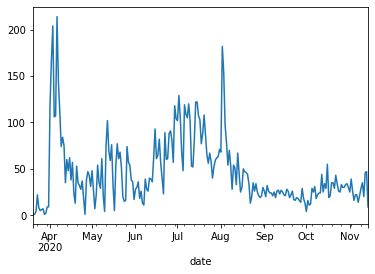

In [22]:
covid_violations_over_time = covid_violations['date'].groupby(covid_violations.date.dt.to_period("D")).agg('count')
#df
covid_violations_over_time.plot()


### Loaded Colleges df

In [23]:
colleges_df = pd.read_sql("select * from colleges;", con=engine)
colleges_df.head(2)

,date,state,county,city,ipeds_id,college,cases,notes
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0,None
1,2020-11-05,Alabama,Montgomery,Montgomery,100724,Alabama State University,NaN,None


### Dropped column "notes"

In [24]:
colleges_df=colleges_df[['date','state','county','city','ipeds_id', 'college','cases']]
colleges_df.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0
1,2020-11-05,Alabama,Montgomery,Montgomery,100724,Alabama State University,NaN


### Dropped missing values

In [25]:
colleges_df_dropped_nan = colleges_df.dropna()
colleges_df_dropped_nan = colleges_df_dropped_nan.reset_index(drop=True)
colleges_df_dropped_nan.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0
1,2020-11-05,Alabama,Limestone,Athens,100812,Athens State University,23.0


### Made sure there were no duplicates

In [26]:
colleges_unique_df = colleges_df_dropped_nan.drop_duplicates(subset=["date","ipeds_id"])
colleges_unique_df = colleges_unique_df.reset_index(drop=True)
colleges_unique_df.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0
1,2020-11-05,Alabama,Limestone,Athens,100812,Athens State University,23.0


###Grouped COVID cases by state

In [27]:
covid_by_c_state = colleges_df_dropped_nan.groupby("state")['cases'].sum()                                              
covid_by_c_state.head(2)

state
Alabama    9858.0
Alaska      105.0
Name: cases, dtype: float64

In [28]:
covid_by_c_state_df = colleges_df_dropped_nan.groupby(['state'], as_index=False)['cases'].sum()
covid_by_c_state_df.head(2)

,state,cases
0,Alabama,9858.0
1,Alaska,105.0


### Sorted  COVID by state list in descending order by the total number of cases.

In [29]:
covid_by_state_sorted = covid_by_c_state_df.sort_values('cases', ascending=False).reset_index(drop=True)
covid_by_state_sorted.head(2)

,state,cases
0,Texas,20036.0
1,Florida,13650.0


Text(0, 0.5, 'No of Cases')

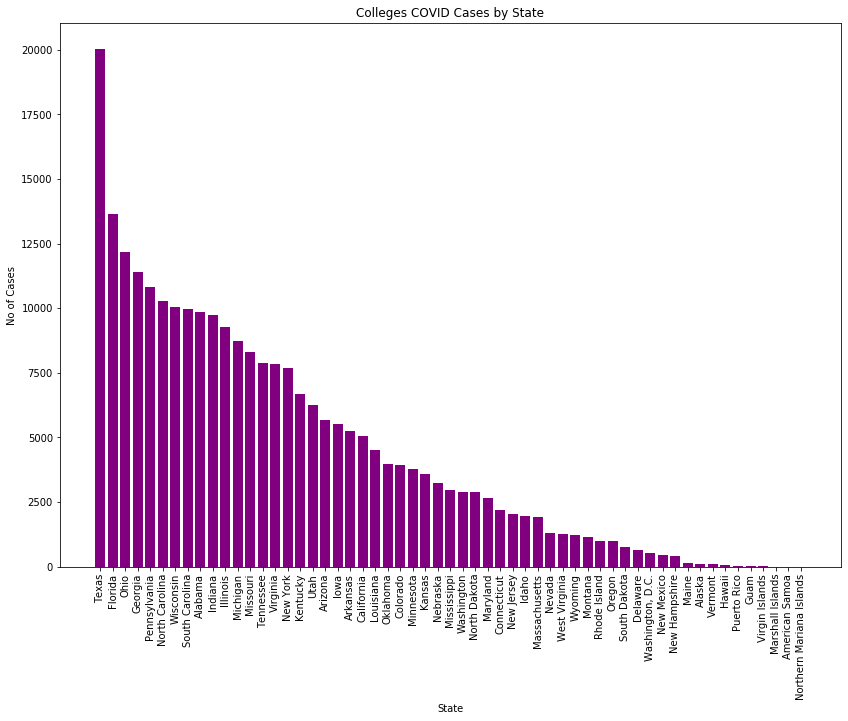

In [60]:
plt.figure(figsize=(14,10))
###covid_by_state_sorted.plot(kind="bar")
plt.bar(covid_by_state_sorted['state'],covid_by_state_sorted['cases'], color = 'purple')
plt.xticks(rotation=90)
plt.title('Colleges COVID Cases by State')
plt.xlabel('State')
plt.ylabel('No of Cases')

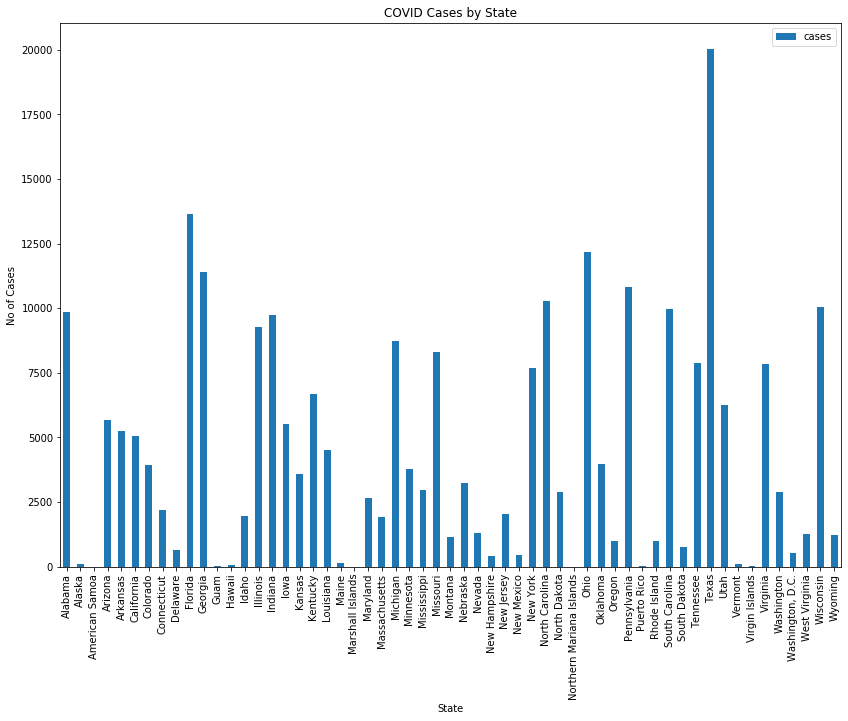

In [31]:
plt.figure(figsize=(14,10))
covid_by_c_state.plot(kind="bar")
plt.xticks(rotation=90)
plt.title('COVID Cases by State')
plt.xlabel('State')
plt.ylabel('No of Cases')
plt.legend(loc='upper right')

<Figure size 1008x720 with 0 Axes>

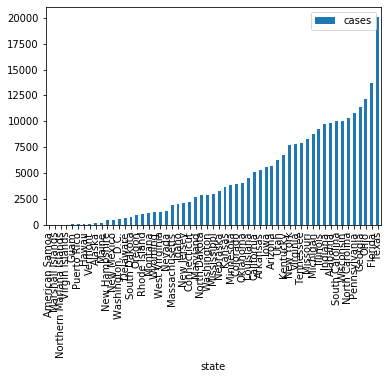

In [32]:
plt.figure(figsize=(14,10))
covid_by_state_sorted.groupby(['state']).median().sort_values("cases").plot.bar()

### Top 10 states with Max No of COVID cases

In [80]:
covid_by_state_sorted = covid_by_c_state_df.sort_values('cases', ascending=False).reset_index(drop=True)
#max_covid_c_by_state_top_10 = covid_by_state_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
max_covid_c_by_state_top_10 = covid_by_state_sorted.loc[[0,1,2,3,4,5,6,7,8,9]]
max_covid_c_by_state_top_10

,state,cases
0,Texas,20036.0
1,Florida,13650.0
2,Ohio,12171.0
3,Georgia,11406.0
4,Pennsylvania,10817.0
5,North Carolina,10296.0
6,Wisconsin,10054.0
7,South Carolina,9974.0
8,Alabama,9858.0
9,Indiana,9736.0


Text(0, 0.5, 'State')

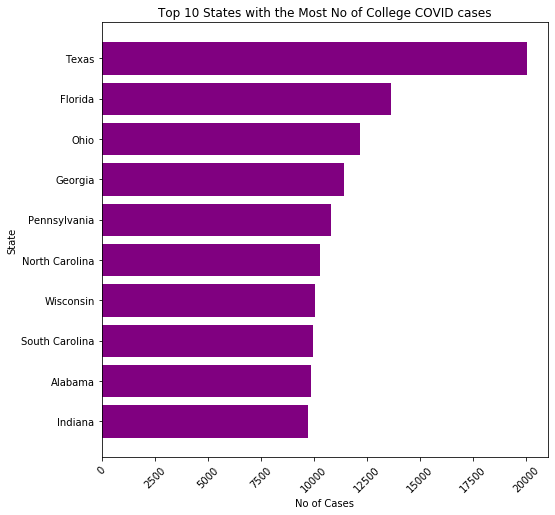

In [65]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(max_covid_c_by_state_top_10['state'],max_covid_c_by_state_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('Top 10 States with the Most No of College COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('State')

### Bottom 10 states with the least no of College COVID cases

In [77]:
covid_by_state_min = covid_by_state_sorted.groupby(["state"])['cases'].aggregate(np.median).reset_index().sort_values('cases')
covid_by_state_min=covid_by_state_min.reset_index(drop=True)
min_covid_c_by_state_top_10 = covid_by_state_min.loc[[9,8,7,6,5,4,3,2,1,0]]
#min_covid_c_by_state_top_10 = covid_by_state_min.loc[[0,1,2,3,4,5,6,7,8,9]]
min_covid_c_by_state_top_10

,state,cases
9,Maine,120.0
8,Alaska,105.0
7,Vermont,91.0
6,Hawaii,41.0
5,Puerto Rico,11.0
4,Guam,9.0
3,Virgin Islands,3.0
2,Northern Mariana Islands,0.0
1,Marshall Islands,0.0
0,American Samoa,0.0


Text(0, 0.5, 'State')

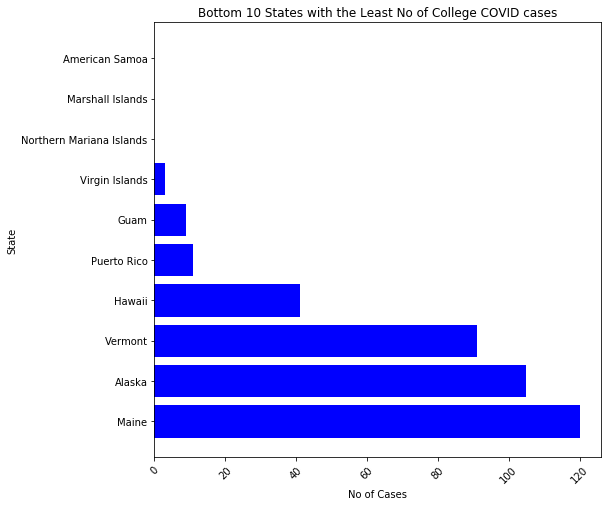

In [78]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(min_covid_c_by_state_top_10['state'],min_covid_c_by_state_top_10['cases'], color = 'blue')
plt.xticks(rotation=45)
plt.title('Bottom 10 States with the Least No of College COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('State')

### COVID no of cases by College

In [37]:
colleges_df_dropped_nan.head(3)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0
1,2020-11-05,Alabama,Limestone,Athens,100812,Athens State University,23.0
2,2020-11-05,Alabama,Lee,Auburn,100858,Auburn University,2047.0


In [38]:
covid_c_by_college = colleges_df_dropped_nan.groupby(['college','state'],as_index=False)['cases'].sum()
covid_c_by_college.head()

,college,state,cases
0,Abilene Christian University,Texas,297.0
1,Abraham Baldwin Agricultural College,Georgia,130.0
2,Adams State University,Colorado,17.0
3,Adelphi University,New York,31.0
4,Adirondack Community College,New York,3.0


### Top 10 Colleges with Max No of COVID cases

In [75]:
covid_c_by_college_sorted=covid_c_by_college.sort_values('cases', ascending=False).reset_index(drop=True)
#covid_c_by_college_top_10 = covid_c_by_college_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
covid_c_by_college_top_10 = covid_c_by_college_sorted.loc[[0,1,2,3,4,5,6,7,8,9]]
covid_c_by_college_top_10

,college,state,cases
0,Clemson University,South Carolina,4831.0
1,University of Florida,Florida,4461.0
2,University of Georgia,Georgia,4198.0
3,Penn State University,Pennsylvania,3883.0
4,Ohio State University,Ohio,3711.0
5,University of Wisconsin-Madison,Wisconsin,3626.0
6,Indiana University Bloomington,Indiana,3369.0
7,University of Illinois Urbana-Champaign,Illinois,3241.0
8,University of Alabama,Alabama,3037.0
9,University of South Carolina,South Carolina,2675.0


Text(0, 0.5, 'College')

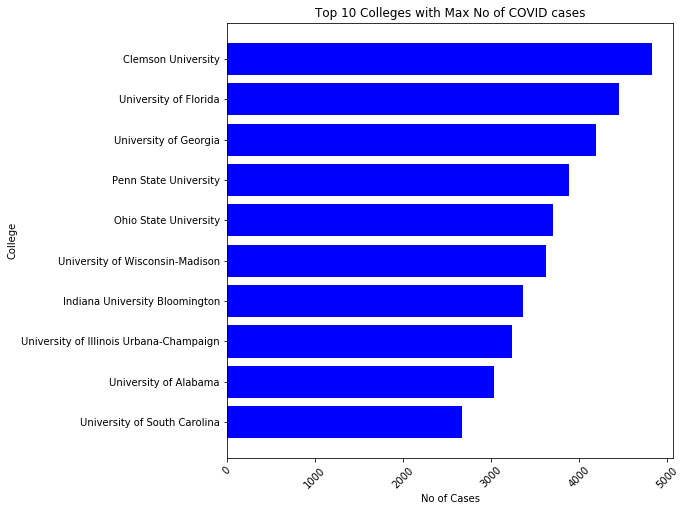

In [73]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(covid_c_by_college_top_10['college'],covid_c_by_college_top_10['cases'], color = 'blue')
plt.xticks(rotation=45)
plt.title('Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')

### No of Colleges by State

In [41]:
colleges_by_state_unique_df = colleges_df_dropped_nan.drop_duplicates(subset=["college"])
ccolleges_by_state_unique_df= colleges_by_state_unique_df.reset_index(drop=True)
colleges_by_state_unique_df.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Alabama,Madison,Huntsville,100654,Alabama A&M University,41.0
1,2020-11-05,Alabama,Limestone,Athens,100812,Athens State University,23.0


In [42]:
boolean = not colleges_by_state_unique_df["college"].is_unique      
boolean = colleges_by_state_unique_df['college'].duplicated().any()
boolean

False

In [43]:
colleges_by_state = colleges_by_state_unique_df['state'].value_counts()
colleges_by_state.head(10)

New York         154
Pennsylvania     112
Florida           90
Texas             82
California        81
Ohio              67
Tennessee         65
Minnesota         58
Massachusetts     57
Kentucky          52
Name: state, dtype: int64

In [44]:
max_covic_c_df=covid_c_by_college_sorted.loc[covid_c_by_college_sorted['cases'].idxmax()]
max_covic_c_df

college    Clemson University
state          South Carolina
cases                    4831
Name: 0, dtype: object

In [45]:
max_covic_c_df=colleges_by_state_unique_df.loc[colleges_by_state_unique_df['cases'].idxmax()]
max_covic_c_df

date                2020-11-05
state           South Carolina
county                 Pickens
city                   Clemson
ipeds_id                217882
college     Clemson University
cases                     4831
Name: 1338, dtype: object

In [46]:
clemson = colleges_df_dropped_nan[(colleges_df_dropped_nan['college'] == 'Clemson University')].reset_index(drop=True)
clemson

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,South Carolina,Pickens,Clemson,217882,Clemson University,4831.0


### New York State has the biggest number of Colleges (155). Let's look at the distribution of COVID cases there.

In [47]:
ny_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'New York')].reset_index(drop=True)
ny_colleges.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,New York,Nassau,Garden City,188429,Adelphi University,31.0
1,2020-11-05,New York,Warren,Queensbury,188438,Adirondack Community College,3.0


In [48]:
ny_colleges_sorted=ny_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
ny_colleges_sorted.head(10)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,New York,Otsego,Oneonta,196185,SUNY Oneonta,730.0
1,2020-11-05,New York,Cortland,Cortland,196149,SUNY Cortland,598.0
2,2020-11-05,New York,Suffolk,Stony Brook,196097,Stony Brook University,524.0
3,2020-11-05,New York,New York City,New York City,193900,New York University,455.0
4,2020-11-05,New York,Oswego,Oswego,196194,SUNY Oswego,295.0
5,2020-11-05,New York,Broome,Vestal,196079,SUNY Binghamton,266.0
6,2020-11-05,New York,Onondaga,Syracuse,196413,Syracuse University,257.0
7,2020-11-05,New York,Erie,Buffalo,196088,SUNY University at Buffalo,249.0
8,2020-11-05,New York,Albany,Albany,196060,SUNY Albany,191.0
9,2020-11-05,New York,Tompkins,Ithaca,190415,Cornell University,185.0


### Now let's look at top 10 Colleges with the most COVID cases in top 5 states

### #1.TEXAS

In [49]:
texas_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'Texas')].reset_index(drop=True)
texas_colleges.head(2)

,date,state,county,city,ipeds_id,college,cases
0,2020-11-05,Texas,Taylor,Abilene,222178,Abilene Christian University,297.0
1,2020-11-05,Texas,Tom Green,San Angelo,222831,Angelo State University,178.0


In [50]:
texas_colleges_sorted=texas_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
texas_colleges_top_10 = texas_colleges_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
texas_colleges_top_10

,date,state,county,city,ipeds_id,college,cases
9,2020-11-05,Texas,Denton,Denton,227216,University of North Texas,474.0
8,2020-11-05,Texas,Walker,Huntsville,227881,Sam Houston State University,652.0
7,2020-11-05,Texas,Dallas,Dallas,228246,Southern Methodist University,757.0
6,2020-11-05,Texas,Hays,San Marcos,228459,Texas State University,797.0
5,2020-11-05,Texas,El Paso,El Paso,228796,University of Texas at El Paso,835.0
4,2020-11-05,Texas,McLennan,Waco,223232,Baylor University,1181.0
3,2020-11-05,Texas,Tarrant,Fort Worth,228875,Texas Christian University,1292.0
2,2020-11-05,Texas,Travis,Austin,228778,University of Texas at Austin,1581.0
1,2020-11-05,Texas,Brazos,College Station,228723,Texas A&M University,2037.0
0,2020-11-05,Texas,Lubbock,Lubbock,229115,Texas Tech University,2259.0


Text(0, 0.5, 'College')

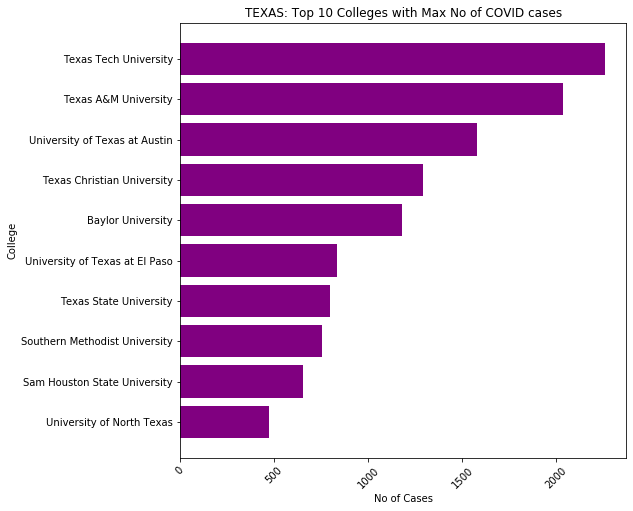

In [51]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(texas_colleges_top_10['college'],texas_colleges_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('TEXAS: Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')

### #2. FLORIDA

In [52]:
fl_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'Florida')].reset_index(drop=True)
fl_colleges_sorted=fl_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
fl_colleges_top_10 = fl_colleges_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
fl_colleges_top_10

,date,state,county,city,ipeds_id,college,cases
9,2020-11-05,Florida,Volusia,DeLand,137546,Stetson University,149.0
8,2020-11-05,Florida,Duval,Jacksonville,136172,University of North Florida,227.0
7,2020-11-05,Florida,Palm Beach,Boca Raton,133669,Florida Atlantic University,310.0
6,2020-11-05,Florida,Lee,Fort Myers,433660,Florida Gulf Coast University,380.0
5,2020-11-05,Florida,Hillsborough,Tampa,137847,University of Tampa,704.0
4,2020-11-05,Florida,Miami-Dade,Miami,135726,University of Miami,746.0
3,2020-11-05,Florida,Hillsborough,Tampa,137351,University of South Florida,770.0
2,2020-11-05,Florida,Leon,Tallahassee,134097,Florida State University,1738.0
1,2020-11-05,Florida,Orange,Orlando,132903,University of Central Florida,1834.0
0,2020-11-05,Florida,Alachua,Gainesville,134130,University of Florida,4461.0


Text(0, 0.5, 'College')

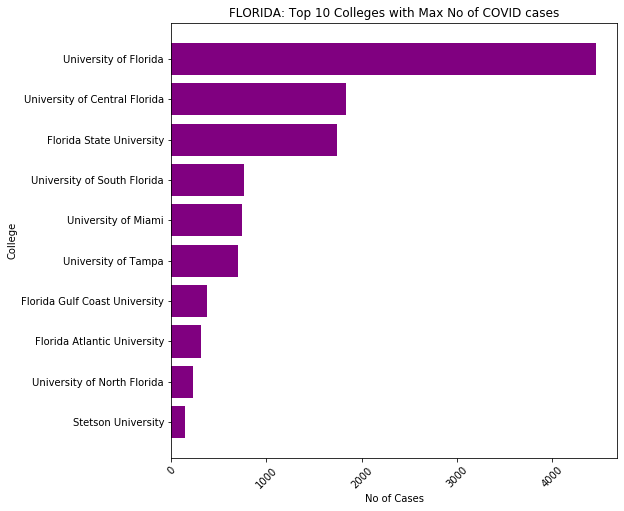

In [53]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(fl_colleges_top_10['college'],fl_colleges_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('FLORIDA: Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')

### #3. OHIO

In [54]:
oh_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'Ohio')].reset_index(drop=True)
oh_colleges_sorted=oh_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
oh_colleges_top_10 = oh_colleges_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
oh_colleges_top_10

,date,state,county,city,ipeds_id,college,cases
9,2020-11-05,Ohio,Delaware,Delaware,204909,Ohio Wesleyan University,125.0
8,2020-11-05,Ohio,Clark,Springfield,206525,Wittenberg University,186.0
7,2020-11-05,Ohio,Portage,Kent,203517,Kent State University,404.0
6,2020-11-05,Ohio,Lucas,Toledo,206084,University of Toledo,421.0
5,2020-11-05,Ohio,Wood,Bowling Green,201441,Bowling Green State University,555.0
4,2020-11-05,Ohio,Athens,Athens,204857,Ohio University,604.0
3,2020-11-05,Ohio,Hamilton,Cincinnati,201885,University of Cincinnati,854.0
2,2020-11-05,Ohio,Montgomery,Dayton,202480,University of Dayton,1455.0
1,2020-11-05,Ohio,Butler,Oxford,204024,Miami University (Ohio),2248.0
0,2020-11-05,Ohio,Franklin,Columbus,204796,Ohio State University,3711.0


Text(0, 0.5, 'College')

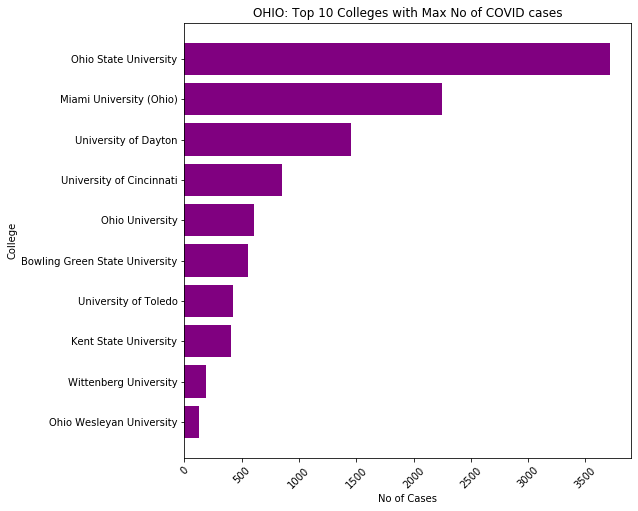

In [55]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(oh_colleges_top_10['college'],oh_colleges_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('OHIO: Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')

### #4.GEORGIA

In [56]:
ga_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'Georgia')].reset_index(drop=True)
ga_colleges_sorted=ga_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
ga_colleges_top_10 = ga_colleges_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
ga_colleges_top_10

,date,state,county,city,ipeds_id,college,cases
9,2020-11-05,Georgia,Fulton,Atlanta,139658,Emory University,234.0
8,2020-11-05,Georgia,Fulton,Atlanta,139940,Georgia State University,278.0
7,2020-11-05,Georgia,Richmond,Augusta,482149,Augusta University,278.0
6,2020-11-05,Georgia,Bibb,Macon,140447,Mercer University,303.0
5,2020-11-05,Georgia,Lumpkin,Dahlonega,482680,University of North Georgia,464.0
4,2020-11-05,Georgia,Cobb,Kennesaw,486840,Kennesaw State University,572.0
3,2020-11-05,Georgia,Baldwin,Milledgeville,139861,Georgia College & State University,747.0
2,2020-11-05,Georgia,Fulton,Atlanta,139755,Georgia Institute of Technology,1102.0
1,2020-11-05,Georgia,Bulloch,Statesboro,139931,Georgia Southern University,1243.0
0,2020-11-05,Georgia,Clarke,Athens,139959,University of Georgia,4198.0


Text(0, 0.5, 'College')

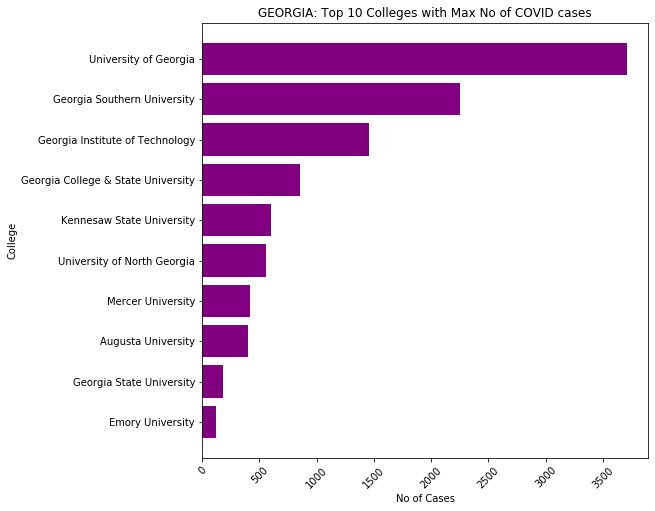

In [57]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(ga_colleges_top_10['college'],oh_colleges_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('GEORGIA: Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')

### #5. PENNSYLVANIA

In [58]:
pa_colleges = colleges_df_dropped_nan[(colleges_df_dropped_nan['state'] == 'Pennsylvania')].reset_index(drop=True)
pa_colleges_sorted=pa_colleges.sort_values('cases', ascending=False).reset_index(drop=True)
pa_colleges_top_10 = pa_colleges_sorted.loc[[9,8,7,6,5,4,3,2,1,0]]
pa_colleges_top_10

,date,state,county,city,ipeds_id,college,cases
9,2020-11-05,Pennsylvania,Northampton,Bethlehem,213543,Lehigh University,262.0
8,2020-11-05,Pennsylvania,Philadelphia,Philadelphia,215770,Saint Joseph's University,278.0
7,2020-11-05,Pennsylvania,Indiana,Indiana,213020,Indiana University of Pennsylvania,312.0
6,2020-11-05,Pennsylvania,Berks,Kutztown,213349,Kutztown University,346.0
5,2020-11-05,Pennsylvania,Columbia,Bloomsburg,211158,Bloomsburg University of Pennsylvania,369.0
4,2020-11-05,Pennsylvania,Allegheny,Pittsburgh,215293,University of Pittsburgh,398.0
3,2020-11-05,Pennsylvania,Lackawanna,Scranton,215929,University of Scranton,620.0
2,2020-11-05,Pennsylvania,Philadelphia,Philadelphia,215062,University of Pennsylvania,660.0
1,2020-11-05,Pennsylvania,Philadelphia,Philadelphia,216339,Temple University,711.0
0,2020-11-05,Pennsylvania,Centre,State College,214777,Penn State University,3883.0


Text(0, 0.5, 'College')

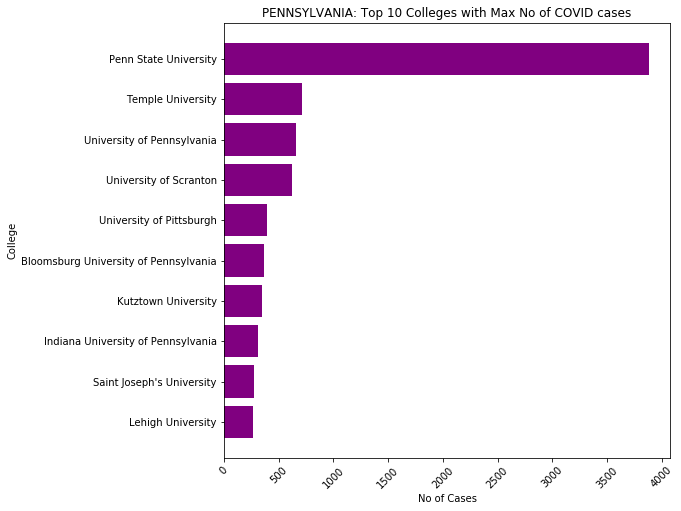

In [59]:
plt.figure(figsize=(8,8))
###covid_c_by_college_top_10.plot(kind="bar")
plt.barh(pa_colleges_top_10['college'],pa_colleges_top_10['cases'], color = 'purple')
plt.xticks(rotation=45)
plt.title('PENNSYLVANIA: Top 10 Colleges with Max No of COVID cases')
plt.xlabel('No of Cases')
plt.ylabel('College')